In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
import os.path
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import metrics
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
os.chdir('C:\\Users\\anear\\OneDrive - National University of Ireland, Galway\\PhD\\Research Projects\\Ventilation Project\\experiments')

Using TensorFlow backend.


# Experiment #1: Patients Re-Intubated after 5 Days

Train recurrent neural network models and logistic regression models:
- including patients re-intubated after 5 days as positive outcomes.
- excluding patients re-intubated after 5 days from the analysis completely.
- excluding patients re-intubated after 5 days from the validation/test sets only.

Compare the AUROC the models achieve on their respective test sets.

In [3]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0005), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
__________________________

In [4]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [5]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [6]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [7]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [8]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, batch_size=32, verbose=1)


Train on 7172 samples, validate on 897 samples
Epoch 1/100
7172/7172 [==============================] - 6s 888us/step - loss: 0.6263 - binary_accuracy: 0.6590 - auc_1: 0.6931 - val_loss: 0.5885 - val_binary_accuracy: 0.7402 - val_auc_1: 0.7473
Epoch 2/100
7172/7172 [==============================] - 8s 1ms/step - loss: 0.5821 - binary_accuracy: 0.7086 - auc_1: 0.7305 - val_loss: 0.5445 - val_binary_accuracy: 0.7425 - val_auc_1: 0.7513
Epoch 3/100
7172/7172 [==============================] - 8s 1ms/step - loss: 0.5652 - binary_accuracy: 0.7243 - auc_1: 0.7426 - val_loss: 0.5393 - val_binary_accuracy: 0.7480 - val_auc_1: 0.7655
Epoch 4/100
7172/7172 [==============================] - 8s 1ms/step - loss: 0.5532 - binary_accuracy: 0.7337 - auc_1: 0.7479 - val_loss: 0.5353 - val_binary_accuracy: 0.7402 - val_auc_1: 0.7696
Epoch 5/100
7172/7172 [==============================] - 8s 1ms/step - loss: 0.5412 - binary_accuracy: 0.7476 - auc_1: 0.7612 - val_loss: 0.5263 - val_binary_accuracy: 0.

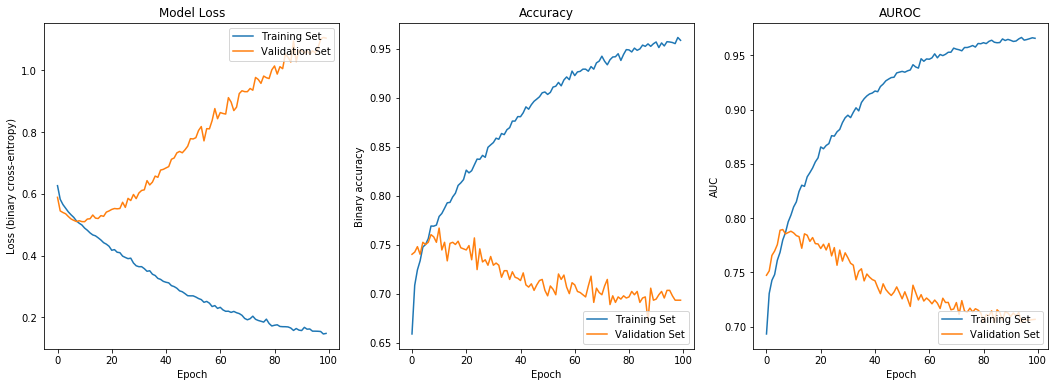

In [9]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_1'])
ax3.plot(history.history['val_auc_1'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()